In [1]:
# library imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from datetime import datetime
from env import get_connection
import os

%matplotlib inline

# pd.plotting.register_matplotlib_converters()

In [2]:
# Constant (to generate filename for csv)
filename = 'curriculum_logs_data.csv'

# Acquire data.
# ----------------------ACQUIRE FUNCTION---------------------------------
def acquire_curlogs():

    '''
    function created to search/retrieve curriculum_logs for codeup exercise
    '''

    if os.path.isfile(filename):
        # If the CSV file exists, read it directly
        return pd.read_csv(filename)
        
    else: 
        query = '''
                SELECT date, path AS endpoint, user_id, cohort_id, ip AS source_ip, name
                FROM cohorts
                LEFT JOIN logs ON cohorts.id = logs.user_id;
                '''

        url = get_connection('curriculum_logs')
                
        df = pd.read_sql(query, url)

        # Convert the 'date' column to datetime format
        df['date'] = pd.to_datetime(df['date'])
        
        # Define the date range
        start_date = '2018-03-01'
        end_date = '2019-03-31'

        # Filter the DataFrame to include only rows within the desired date range
        filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

        # save the filtered DataFrame to CSV
        filtered_df.to_csv(filename, index=False)

        return filtered_df

In [3]:
# called function and assigned to df to return dataframe
df = acquire_curlogs()
# checking info on df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33577 entries, 2742 to 73178
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       33577 non-null  datetime64[ns]
 1   endpoint   33577 non-null  object        
 2   user_id    33577 non-null  int64         
 3   cohort_id  32448 non-null  float64       
 4   source_ip  33577 non-null  object        
 5   name       33577 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 1.8+ MB


In [4]:
# quick view of df
df.head()

,date,endpoint,user_id,cohort_id,source_ip,name
2742,2018-03-24,spring/fundamentals/repositories,52,21.0,172.3.29.85,Europa
2743,2018-03-24,spring/fundamentals/views,52,21.0,172.3.29.85,Europa
2744,2018-03-24,spring/setup,52,21.0,172.3.29.85,Europa
2745,2018-03-24,spring/fundamentals/views,52,21.0,172.3.29.85,Europa
2746,2018-03-24,spring/fundamentals/repositories,52,21.0,172.3.29.85,Europa


In [5]:
# checking the user_id value count within the dataframe
df.user_id.value_counts()

53     5071
11     4023
1      2416
134    1490
135    1459
25     1362
138    1251
5      1152
7      1051
2      1034
3       910
6       893
18      826
61      800
19      787
30      729
136     684
31      646
29      606
60      484
20      471
12      458
10      419
32      415
133     405
14      390
26      380
9       343
27      321
4       301
58      298
34      243
51      179
139     168
23      163
132     157
8       151
52      128
28      111
56      107
57       81
33       67
15       60
21       48
59       21
137      10
16        7
13        1
Name: user_id, dtype: int64

In [6]:
# chnaged acquired dataframe dates to index
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)
# resampled by day for page counts based on visited endpoints
pages = df['endpoint'].resample('d').count()
pages.head()

date
2018-03-01    477
2018-03-02    224
2018-03-03     62
2018-03-04    199
2018-03-05    515
Freq: D, Name: endpoint, dtype: int64

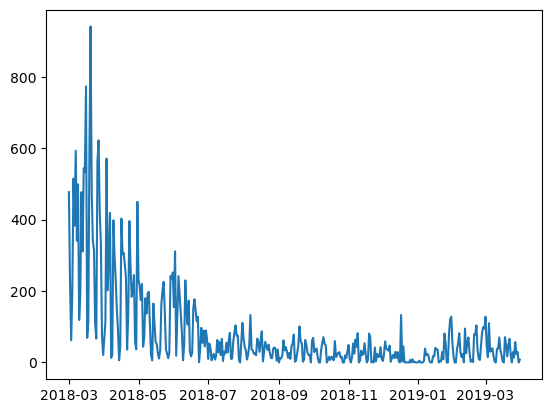

In [7]:
# plotted the page count field to see accessed endpoints daya by day over a year
plt.plot(pages)

## Exponential Moving Averages

In [8]:
# 7 day EMA
ema_7d = pages.ewm(span=7).mean()
ema_7d.head()

date
2018-03-01    477.000000
2018-03-02    332.428571
2018-03-03    215.486486
2018-03-04    209.457143
2018-03-05    309.609475
Freq: D, Name: endpoint, dtype: float64

In [9]:
# 14 days EMA
ema_14d = pages.ewm(span=14).mean()
ema_14d.head()

date
2018-03-01    477.000000
2018-03-02    341.464286
2018-03-03    234.707980
2018-03-04    223.783901
2018-03-05    299.761736
Freq: D, Name: endpoint, dtype: float64

In [10]:
# 30 days EMA
ema_30d = pages.ewm(span=30).mean()
ema_30d.head()


date
2018-03-01    477.000000
2018-03-02    346.283333
2018-03-03    245.136986
2018-03-04    232.424565
2018-03-05    296.717318
Freq: D, Name: endpoint, dtype: float64

In [11]:
# 90 days EMA
ema_90d = pages.ewm(span=90).mean()
ema_90d.head()

date
2018-03-01    477.000000
2018-03-02    349.094444
2018-03-03    251.261882
2018-03-04    237.757706
2018-03-05    295.697613
Freq: D, Name: endpoint, dtype: float64

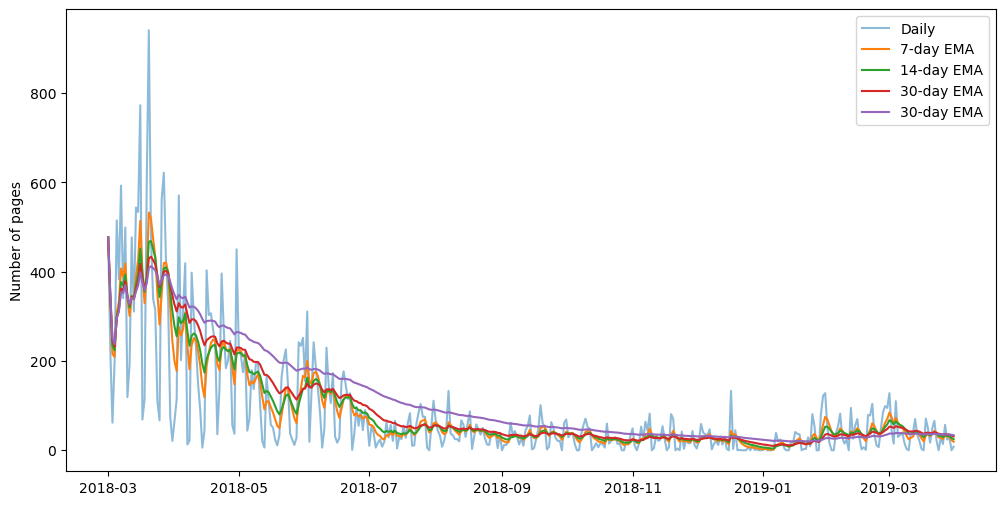

In [12]:
# plotting all exponenital moving averages with daily page count
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '30-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()


In [13]:
# set the window span
span = 30

# compute midband
midband = pages.ewm(span=span).mean()

midband.head()

date
2018-03-01    477.000000
2018-03-02    346.283333
2018-03-03    245.136986
2018-03-04    232.424565
2018-03-05    296.717318
Freq: D, Name: endpoint, dtype: float64

In [14]:
# compute exponential stdev
stdev = pages.ewm(span=span).std()

stdev.head()

date
2018-03-01           NaN
2018-03-02    178.898016
2018-03-03    208.075724
2018-03-04    168.697397
2018-03-05    195.445324
Freq: D, Name: endpoint, dtype: float64

In [15]:
# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3
ub

date
2018-03-01           NaN
2018-03-02    882.977380
2018-03-03    869.364158
2018-03-04    738.516757
2018-03-05    883.053289
                 ...    
2019-03-27    125.860753
2019-03-28    122.620557
2019-03-29    119.509504
2019-03-30    118.629419
2019-03-31    116.286699
Freq: D, Name: endpoint, Length: 396, dtype: float64

In [16]:
# lower bound
lb

date
2018-03-01           NaN
2018-03-02   -190.410714
2018-03-03   -379.090185
2018-03-04   -273.667626
2018-03-05   -289.618653
                 ...    
2019-03-27    -53.213442
2019-03-28    -51.563396
2019-03-29    -49.165708
2019-03-30    -52.823932
2019-03-31    -53.694469
Freq: D, Name: endpoint, Length: 396, dtype: float64

In [17]:
# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)
# name df columns for bollinger bands
bb.columns = ['ub', 'lb']
bb.head()

,ub,lb
date,,
2018-03-01,NaN,NaN
2018-03-02,882.977380,-190.410714
2018-03-03,869.364158,-379.090185
2018-03-04,738.516757,-273.667626
2018-03-05,883.053289,-289.618653


In [18]:
# concatenate pages count and the midband as well and check.
my_df = pd.concat([pages, midband, bb], axis=1)
my_df.columns = ['pages', 'midband', 'ub', 'lb']
my_df.head()

,pages,midband,ub,lb
date,,,,
2018-03-01,477,477.000000,NaN,NaN
2018-03-02,224,346.283333,882.977380,-190.410714
2018-03-03,62,245.136986,869.364158,-379.090185
2018-03-04,199,232.424565,738.516757,-273.667626
2018-03-05,515,296.717318,883.053289,-289.618653


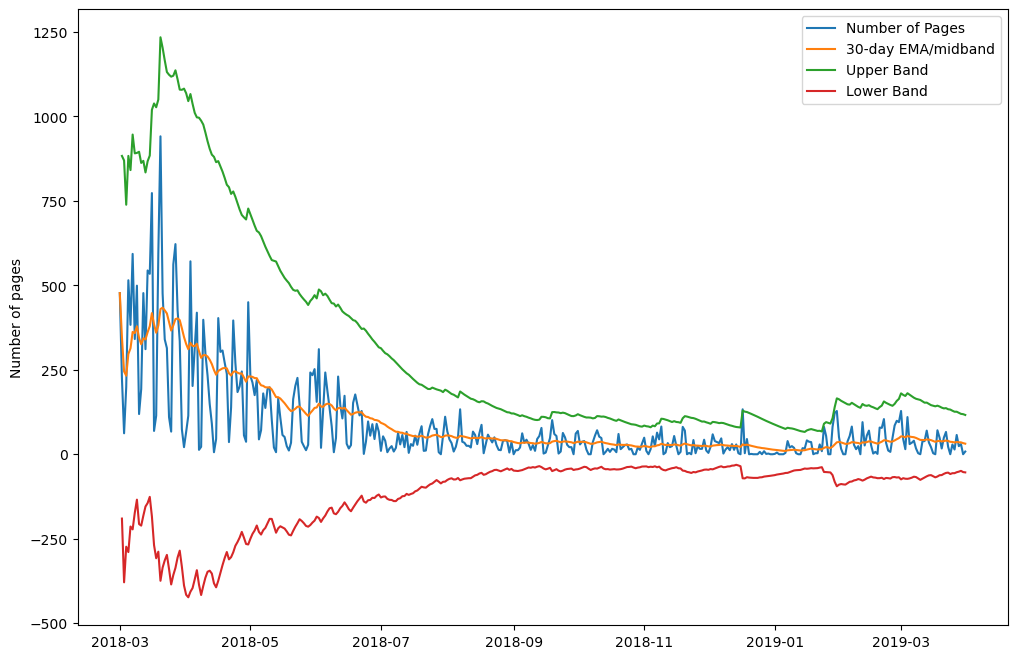

In [19]:
# plotted new dataframe with midband and the number of pages with the bollinger bands
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

In [20]:
# get the last measure of gb
last_measure = my_df.iloc[-1].pages
last_measure

8.0

In [21]:
# get the lower band value on the last date
last_lb = my_df.iloc[-1].lb
last_lb

-53.69446898701899

In [22]:
# get the upper band value on the last date
last_ub = my_df.iloc[-1].ub
last_ub

116.28669875609653

In [23]:
# compute %b
last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)

print('%b for last datapoint: ', round(last_pct_b, 2))

%b for last datapoint:  0.36


In [24]:
# checked tail of df
my_df.tail(3)

,pages,midband,ub,lb
date,,,,
2019-03-29,30,35.171898,119.509504,-49.165708
2019-03-30,0,32.902743,118.629419,-52.823932
2019-03-31,8,31.296115,116.286699,-53.694469


In [25]:
# compute for each data point in time. 
my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])

my_df.head()

,pages,midband,ub,lb,pct_b
date,,,,,
2018-03-01,477,477.000000,NaN,NaN,NaN
2018-03-02,224,346.283333,882.977380,-190.410714,0.386077
2018-03-03,62,245.136986,869.364158,-379.090185,0.353309
2018-03-04,199,232.424565,738.516757,-273.667626,0.466978
2018-03-05,515,296.717318,883.053289,-289.618653,0.686141


In [26]:
# Now we can see anomalies
my_df[my_df['pct_b']>1]

,pages,midband,ub,lb,pct_b
date,,,,,
2018-12-17,133,28.984714,129.123523,-71.154094,1.019356


In [27]:
def acquire(file_name):
    '''
    Acquire function retrieves and retruens the filenamed csv
    '''
    return pd.read_csv(file_name)

def prep(df, user):
    '''
    The prep function resetos the df by user id andsets index as date column which is changes into a datetime object.
    Pages is also created as a column to count the number of times an endpoint is visited daily as counts.
    '''
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages = df['endpoint'].resample('d').count()
    return pages

def compute_pct_b(pages, span, weight, user):
    '''
    Defined function computes the page count for each day and returns a list of dates with corresponding
    pages, midband, ub,	lb, and	pct_b columns.
    '''
    midband = pages.ewm(span=span).mean()
    stdev = pages.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    bb = pd.concat([ub, lb], axis=1)
    my_df = pd.concat([pages, midband, bb], axis=1)
    my_df.columns = ['pages', 'midband', 'ub', 'lb']
    my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

def plt_bands(my_df, user):
    '''
    Defined function to plot all bands and display the EMA of accessed number of pages over a year
    '''
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()

def find_anomalies(df, user, span, weight):
    '''
    Defined function used to return a series of users and page counts for each user either specifically or for all users.
    '''
    pages = prep(df, user)
    my_df = compute_pct_b(pages, span, weight, user)
    # plt_bands(my_df, user)
    return my_df[my_df.pct_b>1]

In [28]:
# retrieving filename
file_name = "curriculum_logs_data.csv"
column_names = ['date', 'endpoint', 'user_id', 'cohort_id', 'source_ip', 'name']
df = acquire(file_name)
df.head()

,date,endpoint,user_id,cohort_id,source_ip,name
0,2018-03-24,spring/fundamentals/repositories,52,21.0,172.3.29.85,Europa
1,2018-03-24,spring/fundamentals/views,52,21.0,172.3.29.85,Europa
2,2018-03-24,spring/setup,52,21.0,172.3.29.85,Europa
3,2018-03-24,spring/fundamentals/views,52,21.0,172.3.29.85,Europa
4,2018-03-24,spring/fundamentals/repositories,52,21.0,172.3.29.85,Europa


In [34]:
# set keyword arguements to filter by user id #1; display over 30 day period; weight set to 6 to calculta the upper band and lower band.
user = 1
span = 30
weight = 6
user_df = find_anomalies(df, user, span, weight)
# create an empty dataframe called anomalies
anomalies = pd.DataFrame()
# call function anf concatenate the dataframes
user_df = find_anomalies(df, user, span, weight)
anomalies = pd.concat([anomalies, user_df], axis=0)

/var/folders/hz/r10rvhgs41x5bxdmg79hksdw0000gn/T/ipykernel_58858/1079813165.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.date = pd.to_datetime(df.date)
/var/folders/hz/r10rvhgs41x5bxdmg79hksdw0000gn/T/ipykernel_58858/1079813165.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.date = pd.to_datetime(df.date)


In [40]:
span = 30
weight = 3.5
# here we are looping through all user ids
anomalies = pd.DataFrame()
for u in list(df.user_id.unique()):
    user_df = find_anomalies(df, u, span, weight)
    anomalies = pd.concat([anomalies, user_df], axis=0)

/var/folders/hz/r10rvhgs41x5bxdmg79hksdw0000gn/T/ipykernel_58858/1079813165.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.date = pd.to_datetime(df.date)
/var/folders/hz/r10rvhgs41x5bxdmg79hksdw0000gn/T/ipykernel_58858/1079813165.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.date = pd.to_datetime(df.date)
/var/folders/hz/r10rvhgs41x5bxdmg79hksdw0000gn/T/ipykernel_58858/1079813165.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [51]:
# returning counted values of anomolous visited pages
anomalies.pages.value_counts(sort=False)

4      2
18     2
25     1
23     2
11     3
5      1
19     2
13     3
34     1
74     1
17     2
29     1
3      4
38     1
6      2
27     1
10     2
9      3
31     1
7      1
33     1
59     1
198    1
2      1
44     1
Name: pages, dtype: int64

In [52]:
# filtered by user_id 1 (Arches)
anomalies[anomalies.pages==44]

,pages,midband,ub,lb,pct_b,name
date,,,,,,
2019-01-29,44,3.623334,42.081344,-34.834677,1.024945,Arches


In [54]:
# filtered by cohort names and staff accesses
anomalies.name

date
2018-12-01        Quincy
2018-04-23        Deimos
2018-11-09        Deimos
2018-09-19      Wrangell
2018-11-20      Wrangell
2019-03-13      Wrangell
2018-06-28        Darden
2018-07-31        Joshua
2018-08-23        Joshua
2018-10-04        Oberon
2018-06-02      Franklin
2019-03-18      Franklin
2018-08-31     Pinnacles
2019-02-27     Pinnacles
2018-07-18       Sequoia
2018-07-19    Everglades
2019-01-18        Balboa
2019-02-21        Balboa
2018-06-14         Staff
2018-09-08         Staff
2018-08-06         Ceres
2018-11-06         Ceres
2018-12-17         Ceres
2018-04-23      Ganymede
2018-06-19      Ganymede
2018-10-18      Ganymede
2018-06-14          Apex
2018-09-24      Hyperion
2018-10-20      Hyperion
2019-02-20      Hyperion
2018-06-02       Neptune
2018-12-15       Neptune
2018-10-10        Lassen
2019-01-29        Arches
2018-09-13     Andromeda
2018-06-01       Mammoth
2018-08-12       Mammoth
2018-10-08        Xanadu
2019-02-23        Xanadu
2018-10-15      Carl

## Anomalies found by user_id and now displayed by names.